<a href="https://colab.research.google.com/github/georgette707/My-Projects-ML-DATA-SCIENCE-/blob/main/CNN_Keras_Blanked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Convolutional Neural Networks

In image processing, convolution is a mathematical operation performed on an image in order to transform it. An image is convolved with a kernel (a matrix that is usually much smaller than the image, also called filter) by translating the kernel over the image pixel by pixel and replacing each pixel with the sum-product of the filter and the portion of the image it covers.

The kernel can be designed to fulfill a specific transformation such as blurring, sharpening and edge detection.

Convolutional neural networks (CNN) stem from this idea. In a convolutional layer, the input matrix is convolved with a number of kernels to produce a number of output matrices (called feature maps). The key is that the values inside the kernels are not hand-crafted but are weights that are learned instead. Using backpropagation, these weights are updated so that the kernels perform the necessary transformations to produce the desired outputs.

In traditional fully connected networks, every input feature has a weight associated with each neuron in the following layer. In a CNN, the kernel weights are shared among the features. Meaning that we learn a set number of kernel weights regardless of the feature dimensionality. This parameter sharing configuration greatly reduces the number of weights and results in learning position invariant parameters.

CNNs are behind the state-of-the-art advances in computer vision. In this notebook, we will demonstrate the use of CNNs for the simplest computer vision task: image classification.

We will use the [Car-Plane-Ship](https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar) classification dataset from Kaggle.

First, you need to create an account on Kaggle, then go to the Account -> Create new API token. You will get a genearted json file which contains the username and the API, you will need both to download the dataset in the cell that follows.

First we will start by downloading the dataset from Kaggle and setting the random seed for reproducibility.

In [1]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: georgettetarabay
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abtabm/multiclassimagedatasetairplanecar


100%|██████████| 333M/333M [00:05<00:00, 66.5MB/s]


In [2]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

##1) Data Loading and Preprocessing

The dataset is structured such that every folder represents a class and the images within belong to that class. It is also already split into train and test sets.

We need to create two arrays:
- The X array which contains the images. All images must have the same size so we will resize them to a width and height of 128$\times$128. Keras uses the channel last format which means that the channel dimension will be the last. Since our images are RGB we will have three channels. As a result, every image will have a shape of (128, 128, 3). Also, we normalize the pixel values to be between 0 and 1 by dividing by the maximum pixel value (255). We group all of the images into one array where the first dimension will be the sample size.
- The y array which will have a label for each image in X. The labels will be assigned based on the parent directory.

After exploring the dataset structure, define a function to load and preprocess the data according to the following:
- Read the images into memory. For each image also record its label.
- Resize the width and height of each image to (128, 128). All images must have a uniform shape.
- Handle image exeptions that are not strictly RGB.
- Scale the pixel values.
- Stack the images into a single array X of shape (Number of samples, 128, 128, 3).
- Create an array y of labels.
- Return X and y.

In [3]:
import os
import os.path as osp
import numpy as np
from PIL import Image

def load_data(dir):
    images = []
    labels = []
    for category in os.listdir(dir):
        for image_file in os.listdir(osp.join(dir,category)):
            img = Image.open(osp.join(dir,category,image_file))
            #resize all images to the same width and height
            img = img.resize((128,128))
            #some images in this dataset have 4 channels (RGBA)
            #the "convert" method can handle those
            img = img.convert("RGB")
            #convert from PIL to numpy array with float values between 0 and 1
            img = np.array(img)/255.0
            images.append(img)
            labels.append(category)
    #X is of shape number_of_samples, 128, 128, 3
    X = np.array(images)
    Y= np.array(labels)
    return X,Y


- Now call this function for both training and tetsing sets.

In [4]:


#!pwd
#!ls
#!ls /content/multiclassimagedatasetairplanecar
#!ls /content/multiclassimagedatasetairplanecar/Dataset
train_dir = "/content/multiclassimagedatasetairplanecar/Dataset/train"
test_dir = "/content/multiclassimagedatasetairplanecar/Dataset/test"

X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)


#X_train, y_train = load_data(train_dir)
#X_test, y_test = load_data(test_dir)

y_train[y_train == 'ship'] = 'ships'

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3000, 128, 128, 3) (3000,)
(582, 128, 128, 3) (582,)


- Convert the y arrays from string to one-hot encoding format.

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


le=LabelEncoder()
y_train_int=le.fit_transform(y_train)
y_test_int=le.fit_transform(y_test)

#print("Classes:", le.classes_)
#print("y_train_int[:20] =", y_train_int[:20])

y_train_ohe= to_categorical(y_train_int)
y_test_ohe= to_categorical(y_test_int)
#print("Shape of y_train_ohe:", y_train_ohe.shape)
#print("Shape of y_test_ohe :", y_test_ohe.shape)


#2) Data Exploration

- Explore the dataset by displaying a number of images along with their labels.

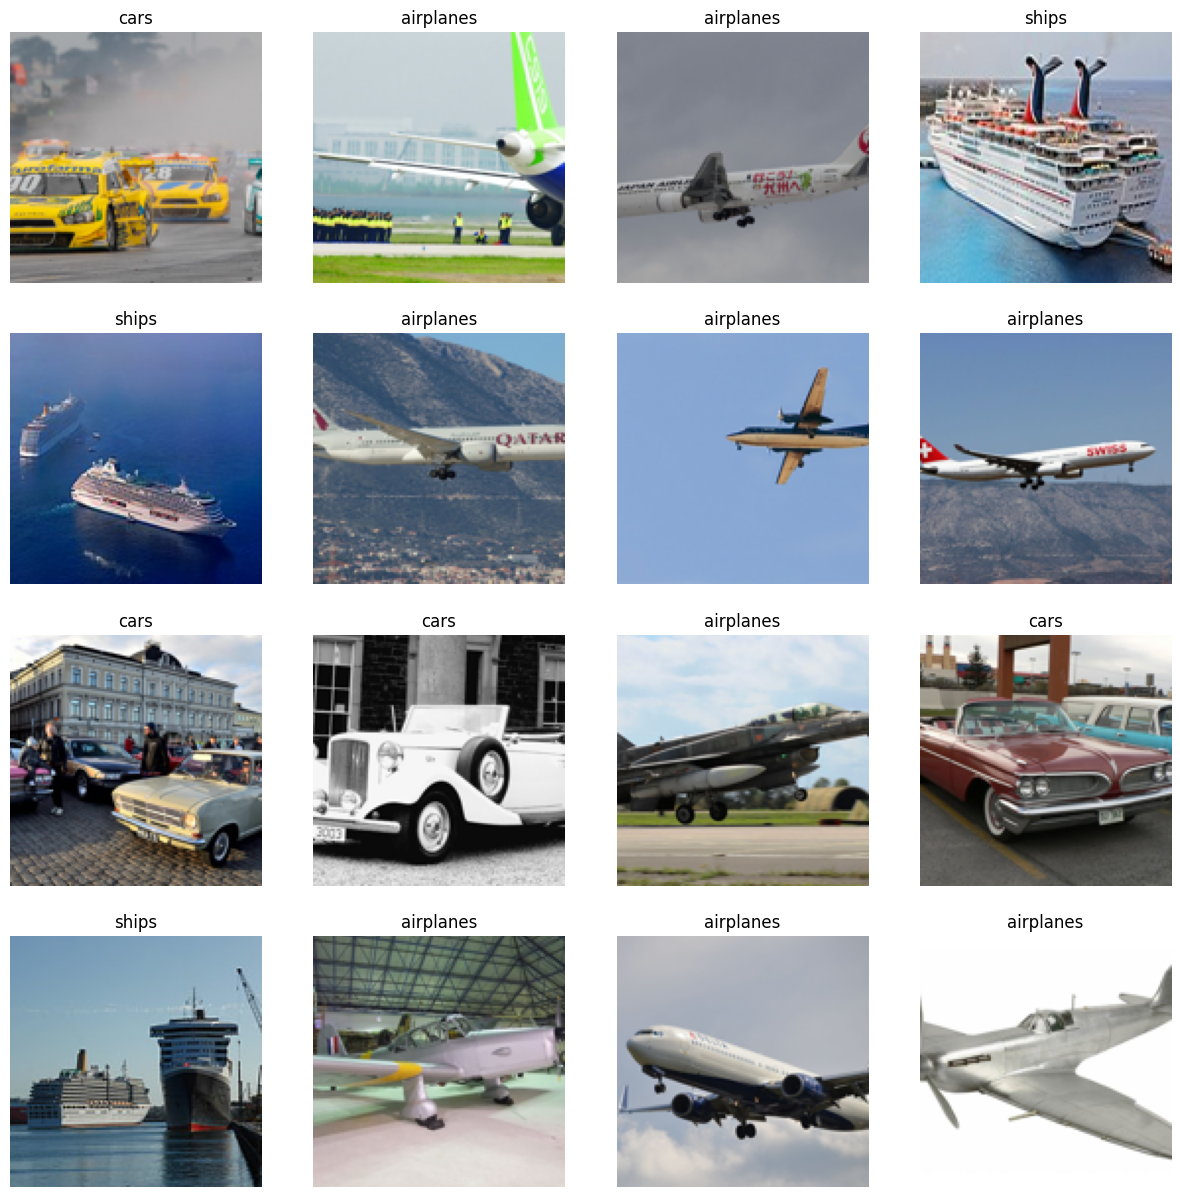

In [6]:
import matplotlib.pyplot as plt
import random
#i did this step to display more than just one category
rand_idxs = random.sample(range(len(X_train)), 16)
plt.figure(figsize=(15,15))

for i, idx in enumerate(rand_idxs):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[idx])
    plt.title(str(y_train[idx]))
    plt.axis('off')
plt.show()

#3) Neural Network

Before we jump into building our first CNN, let's try to use a fully connected network for our image classification.

We will build a traditional multiclass classification network comprised of stacked dense layers and ending with a softmax layer.

The only difference that needs to be taken into account is that a dense network expects features to be arranged in a one-dimensional array. In the case of images, every pixel is a feature but they are arranged in a two-dimensional structure. Therefore, we need to flatten the images into 1D arrays when inputting then into the network. This can be easily done by adding a "Flatten" layer at the beginning of our network. The "Flatten" layer is a Keras layer that does not learn any weights but simply flattens its input into 1D.

- Build a fully connected neural network.
- Train it on the data and show the training and validation loss curves.
- Play with the different hyperparameters (number of layer, number of neurons, optimizer, regularization, epochs, batch size...) until you obtain a satisfactory performance.

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([Flatten(input_shape=(128, 128, 3)),Dense(256, activation='relu'),Dropout(0.3),Dense(128, activation='relu'),Dense(3, activation='softmax')])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,583,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,616,451 (48.13 MB)

 Trainable params: 12,616,451 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

- Compute the following evaluation metrics on the test set: accuracy, precision, recall and F1-score.

In [8]:
from sklearn.metrics import classification_report
history = model.fit(
    X_train, y_train_ohe,
    validation_data=(X_test, y_test_ohe),
    epochs=10,
    batch_size=32
)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_ohe, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))



Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.4132 - loss: 7.0331 - val_accuracy: 0.6443 - val_loss: 0.9424
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 52s 408ms/step - accuracy: 0.4981 - loss: 1.0186 - val_accuracy: 0.6048 - val_loss: 0.8615
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 283ms/step - accuracy: 0.5062 - loss: 0.9345 - val_accuracy: 0.6151 - val_loss: 0.8401
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.5046 - loss: 0.9646 - val_accuracy: 0.5979 - val_loss: 0.8293
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - accuracy: 0.4584 - loss: 1.0079 - val_accuracy: 0.5842 - val_loss: 0.9076
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.5334 - loss: 0.9549 - val_accuracy: 0.5206 - val_loss: 0.8405
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 259ms/step - accuracy: 0.5337 - loss: 0.9598 - val_accuracy: 0.6271 - val_loss: 0.8493
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - accuracy: 0.5136 - loss: 0.9746 - val_accu

#4) Convolutional Neural Network

Our fully connected network did not provide very impressive results. We will improve our results by switching to a convolutional architecture.

The main components of the network will be the Conv2D and MaxPooling2D layers.
- The Conv2D performs the two dimensional convolution previously described. The essential hyperparameters to specify are "filters" which is the number of filters to learn and therefore the number of output feature maps and "kernel_size" which indicates the kernel width and height. There are other more advanced configurations to tweak such as strides, padding and dilation.
- Max pooling uses a kernel similarly to convolution. However, this kernel does not have weights and simply performs the max operation over the pixels. Max pooling is a technique used to summarize the feature maps after convolution to select only the most important features while reducing the size of the feature maps. Similarly to "kernel_size", "pool_size" indicates the size of the pooling kernel.

Multiple convolutional and pooling layers can be stacked but eventually, we need a dense layer to produce our class predictions. As explained before, the dense layer needs to be preceded by a flatten layer.

- Repeat the same steps as Question 3 but using a convolutional neural network.

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

model_cnn = Sequential([

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),


    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),




    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_cnn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,821,763 (56.54 MB)

 Trainable params: 14,821,763 (56.54 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from sklearn.metrics import classification_report
history_cnn = model_cnn.fit(
    X_train, y_train_ohe,
    validation_data=(X_test, y_test_ohe),
    epochs=10,
    batch_size=32
)


y_pred = model_cnn.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_ohe, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=['airplanes', 'cars', 'ships']))

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.5555 - loss: 1.2386 - val_accuracy: 0.8505 - val_loss: 0.4197
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.8590 - loss: 0.3776 - val_accuracy: 0.8729 - val_loss: 0.3273
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.8775 - loss: 0.3201 - val_accuracy: 0.8952 - val_loss: 0.2458
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.9233 - loss: 0.2000 - val_accuracy: 0.9107 - val_loss: 0.2190
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.9503 - loss: 0.1385 - val_accuracy: 0.9141 - val_loss: 0.2272
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.9490 - loss: 0.1432 - val_accuracy: 0.8986 - val_loss: 0.3112
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9536 - loss: 0.1155 - val_accuracy: 0.8832 - val_loss: 0.3937
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9774 - loss: 0.0690 - val_accuracy: 0.8333 - v

##5) Transfer Learning

There is a clear advantage and improvement with the CNN compared to the fully connected network. But can we do better?

We can try to experiment with different CNN configurations and optimize hyperparatmeters. But there is a quicker way.

The ImageNet Large Scale Visual Recognition Challenge is an image classification and object detection challenge that led to a revolution in the computer vision field.

Every iteration of this challenge has led to the development of novel CNN architectures that became state-of-the-art in visual recognition tasks. These networks are very large and were trained on very large data for long durations. Additionally, most them introduced new mechanics such as residual connections and inception modules.

Luckily, these networks along with their learned weights are publicly available. Transfer learning is a technique that uses a pre-trained model and fine tunes it on different yet similar task.

For our task, we will load Inception, which is an Imagenet model and fine tune it. Imagenet has 1000 output classes but our dataset has only 3. So we will cut the last dense layer from Inception and replace it with our own.
Additionally, we will freeze all the pre-trained Inception weights since they already learned very robust image representation on Imagenet and only train the dense layer we added.

- Load the InceptionV3 network without the top (last) dense layer. Set the pooling operation performed after the last convolution to max pooling.
- Create your own dense layer for classification and link it to the output of the Inception model using the Keras Functional API.
- Set the Inception weights to be non-trainable.
- Train and evaluate the model as before.

In [41]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session

clear_session()
#create the pre-trained model
inception_model = InceptionV3(weights='imagenet', include_top=False ,input_shape=(128,128,3), pooling='max')

#add a dense and softmax layer using the Functional API
x = inception_model.output
x = Dense(128, activation='relu')(x)       # a hidden layer
predictions = Dense(3, activation='softmax')(x)

#full model
model1 = Model(inputs=inception_model.input, outputs=predictions)

#freeze all InceptionV3 layers
#this means that the gradient will not be computed for these weights
#and they will not be updates
for layer in inception_model.layers:
    layer.trainable = False

model1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 63, 63, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 63, 63, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 61, 61, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 61, 61, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 61, 61, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 61, 61, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 30, 30, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 30, 30, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [42]:
from sklearn.metrics import classification_report
from tensorflow.keras.applications.inception_v3 import preprocess_input


X_train_inp = preprocess_input(X_train * 255)
X_test_inp = preprocess_input(X_test * 255)
history = model1.fit(
    X_train_inp, y_train_ohe,
    validation_data=(X_test_inp, y_test_ohe),
    epochs=10,
    batch_size=32
)

# Evaluate
y_pred = model1.predict(X_test_inp)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test_ohe.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=['airplanes','cars','ships']))

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8067 - loss: 1.1825 - val_accuracy: 0.9811 - val_loss: 0.0736
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9794 - loss: 0.0646 - val_accuracy: 0.9828 - val_loss: 0.0678
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9900 - loss: 0.0345 - val_accuracy: 0.9845 - val_loss: 0.0738
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9961 - loss: 0.0202 - val_accuracy: 0.9811 - val_loss: 0.0793
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9981 - loss: 0.0111 - val_accuracy: 0.9863 - val_loss: 0.0583
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 0.9845 - val_loss: 0.0722
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9845 - val_loss: 0.0634
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9983 - loss: 0.0048 - val_accuracy: 0.9863 - v

#6) Model Inference

- Download an image from the Internet and use your model to classify the image.

Image downloaded: test_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predictions (raw probabilities): [[6.4064006e-05 2.3629664e-06 9.9993360e-01]]
Predicted class: ships


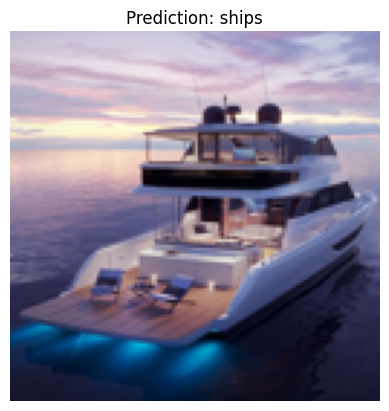

In [54]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.inception_v3 import preprocess_input

image_url = "https://i.pinimg.com/736x/1a/d8/fb/1ad8fb5a53bec0da7fa1da05376db631.jpg"
local_filename = "test_image.jpg"

response = requests.get(image_url, stream=True)
if response.status_code == 200:
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    print("Image downloaded:", local_filename)



img = Image.open(local_filename).convert("RGB")  #  RGB format
img = img.resize((128, 128))  # Resize  input size
img_array = np.array(img, dtype='float32')
img_array = preprocess_input(img_array)
input_batch = np.expand_dims(img_array, axis=0)


predictions = model1.predict(input_batch)
print("Predictions (raw probabilities):", predictions)


class_names = ["airplanes", "cars", "ships"]
pred_class = np.argmax(predictions, axis=1)[0]
predicted_label = class_names[pred_class]
print("Predicted class:", predicted_label)


plt.imshow(img)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()
